In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import json
import time
import os

In [2]:
tf.__version__

'2.2.0'

## 配置参数

In [3]:
#当前路径
work_path = 'D:/python-project/crnn_by_tensorflow2.2.0/'
#是否保存模型
is_save_model = False
#保存模型版本号
version = 1
#模型保存地址
export_path = work_path + 'output/crnn/{0}'.format(str(version))
AUTOTUNE = tf.data.experimental.AUTOTUNE
#测试文件目录
test_path = work_path + 'dataset/test/'
print('测试文件目录：\n', test_path)
print('模型保存地址：\n', export_path)

测试文件目录：
 D:/python-project/jupyter_file/dataset/test/
模型保存地址：
 D:/python-project/jupyter_file/output/crnn/1


## 字符字典

In [4]:
table_path = work_path + "dataset/table.txt"
json_path = work_path + "dataset/char.json"
with open(json_path,'r') as f:
    chardic = json.load(f)
with open(table_path,'w',encoding='utf8') as fw:
    for char in chardic:
        fw.write(char+'\n')
num_classes = len(chardic) + 3
print('字符数：', num_classes)

字符数： 5531


In [5]:
table = tf.lookup.StaticHashTable(tf.lookup.TextFileInitializer(table_path, 
                                                                tf.string, 
                                                                tf.lookup.TextFileIndex.WHOLE_LINE, 
                                                                tf.int64, tf.lookup.TextFileIndex.LINE_NUMBER), num_classes-2)

## 数据预处理

In [6]:
def preprocess_image(image, mode='draw'):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [32, 280])
    if mode == 'draw':
        image /= 255.0  # normalize to [0,1] range
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image, mode='draw')

def load_and_preprocess_image_pridict(path):
    image = tf.io.read_file(path)
    return preprocess_image(image, mode='predict')

def decode_label(img,label):
    chars = tf.strings.unicode_split(label, "UTF-8")
    tokens = tf.ragged.map_flat_values(table.lookup, chars)
    tokens = tokens.to_sparse()
    return img,tokens

In [7]:
class Decoder:
    def __init__(self, table, blank_index=num_classes-2, merge_repeated=True):
        """
        
        Args:
            table: list, char map
            blank_index: int(default: num_classes - 1), the index of blank 
        label.
            merge_repeated: bool
        """
        self.table = table
        if blank_index == num_classes-2:
            blank_index = len(table) - 1
        self.blank_index = blank_index
        self.merge_repeated = merge_repeated

    def map2string(self, inputs):
        strings = []
        for i in inputs:
            text = [self.table[char_index] for char_index in i 
                    if char_index != self.blank_index]
            strings.append(''.join(text))
        return strings

    def decode(self, inputs, from_pred=True, method='greedy'):
        if from_pred:
            logit_length = tf.fill([tf.shape(inputs)[0]], tf.shape(inputs)[1])
            if method == 'greedy':
                decoded, _ = tf.nn.ctc_greedy_decoder(
                    inputs=tf.transpose(inputs, perm=[1, 0, 2]),
                    sequence_length=logit_length,
                    merge_repeated=self.merge_repeated)
            elif method == 'beam_search':
                decoded, _ = tf.nn.ctc_beam_search_decoder(
                    inputs=tf.transpose(inputs, perm=[1, 0, 2]),
                    sequence_length=logit_length)
            inputs = decoded[0]
        decoded = tf.sparse.to_dense(inputs, 
                                     default_value=self.blank_index).numpy()
        decoded = self.map2string(decoded)
        return decoded

## 构造数据集

In [8]:
#测试数据集
test_all_image_paths = [test_path + img for img in sorted(os.listdir(test_path))]

In [9]:
test_images_num = len(test_all_image_paths)
test_steps_per_epoch = test_images_num
test_ds = tf.data.Dataset.from_tensor_slices(test_all_image_paths)
test_ds = test_ds.map(load_and_preprocess_image_pridict, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.repeat()
test_ds = test_ds.batch(len(test_all_image_paths))
test_ds = test_ds.apply(tf.data.experimental.ignore_errors())
test_ds = test_ds.prefetch(AUTOTUNE)

## 模型加载

In [21]:
model = tf.keras.models.load_model(work_path + 'output/crnn_5.h5', compile=False)

In [22]:
class CTCLoss(tf.keras.losses.Loss):
    def __init__(self, logits_time_major=False, blank_index=-1, 
                 reduction=tf.keras.losses.Reduction.AUTO, name='ctc_loss'):
        super().__init__(reduction=reduction, name=name)
        self.logits_time_major = logits_time_major
        self.blank_index = blank_index

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        logit_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        loss = tf.nn.ctc_loss(
            labels=y_true,
            logits=y_pred,
            label_length=None,
            logit_length=logit_length,
            logits_time_major=self.logits_time_major,
            blank_index=self.blank_index)
        return tf.reduce_mean(loss)

In [23]:
class WordAccuracy(tf.keras.metrics.Metric):
    """
    Calculate the word accuracy between y_true and y_pred.
    """
    def __init__(self, name='word_accuracy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total', dtype=tf.int32, 
                                     initializer=tf.zeros_initializer())
        self.count = self.add_weight(name='count', dtype=tf.int32, 
                                     initializer=tf.zeros_initializer())

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        Maybe have more fast implementation.
        """
        b = tf.shape(y_true)[0]
        max_width = tf.maximum(tf.shape(y_true)[1], tf.shape(y_pred)[1])
        logit_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])        
        decoded, _ = tf.nn.ctc_greedy_decoder(
            inputs=tf.transpose(y_pred, perm=[1, 0, 2]),
            sequence_length=logit_length)
        y_true = tf.sparse.reset_shape(y_true, [b, max_width])
        y_pred = tf.sparse.reset_shape(decoded[0], [b, max_width])
        y_true = tf.sparse.to_dense(y_true, default_value=-1)
        y_pred = tf.sparse.to_dense(y_pred, default_value=-1)
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(y_pred, tf.int32)
        values = tf.math.reduce_any(tf.math.not_equal(y_true, y_pred), axis=1)
        values = tf.cast(values, tf.int32)
        values = tf.reduce_sum(values)
        self.total.assign_add(b)
        self.count.assign_add(b - values)

    def result(self):
        return self.count / self.total

    def reset_states(self):
        self.count.assign(0)
        self.total.assign(0)

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  295168    
_________________________________________________________________
batch_normalization (BatchNo multiple                  32        
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  5

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=CTCLoss(), metrics=[WordAccuracy()])

## 模型测试

In [26]:
test_data = next(iter(test_ds))

In [27]:
result = model.predict(test_data)

In [28]:
with open(table_path, 'r',encoding='utf8') as f:
    inv_table = [char.strip() for char in f]+[' ']*2
    
decoder = Decoder(inv_table)

---------------------------------------


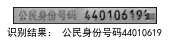

---------------------------------------


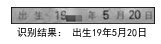

---------------------------------------


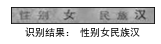

---------------------------------------


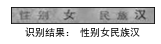

---------------------------------------


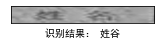

---------------------------------------


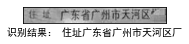

---------------------------------------


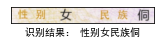

---------------------------------------


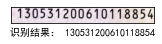

---------------------------------------


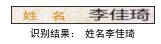

---------------------------------------


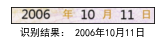

---------------------------------------


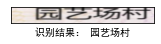

---------------------------------------


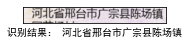

---------------------------------------


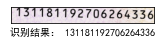

---------------------------------------


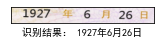

---------------------------------------


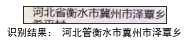

---------------------------------------


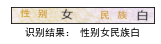

---------------------------------------


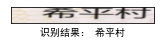

---------------------------------------


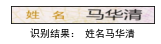

---------------------------------------


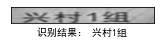

---------------------------------------


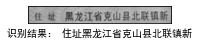

---------------------------------------


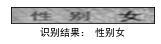

---------------------------------------


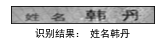

---------------------------------------


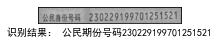

---------------------------------------


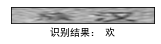

---------------------------------------


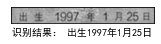

---------------------------------------


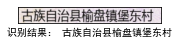

---------------------------------------


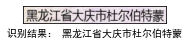

---------------------------------------


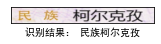

---------------------------------------


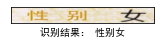

---------------------------------------


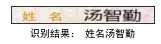

---------------------------------------


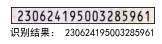

---------------------------------------


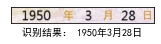

---------------------------------------


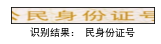

---------------------------------------


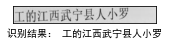

---------------------------------------


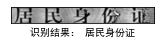

---------------------------------------


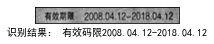

---------------------------------------


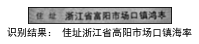

---------------------------------------


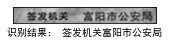

---------------------------------------


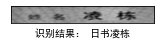

---------------------------------------


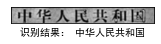

---------------------------------------


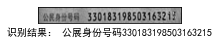

---------------------------------------


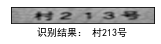

---------------------------------------


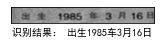

---------------------------------------


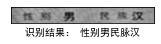

---------------------------------------


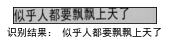

---------------------------------------


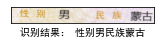

---------------------------------------


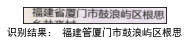

---------------------------------------


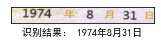

---------------------------------------


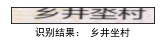

---------------------------------------


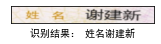

---------------------------------------


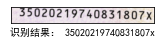

---------------------------------------


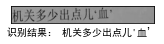

---------------------------------------


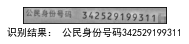

---------------------------------------


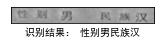

---------------------------------------


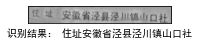

---------------------------------------


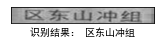

---------------------------------------


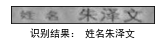

---------------------------------------


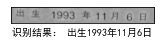

---------------------------------------


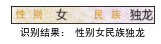

---------------------------------------


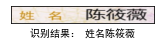

---------------------------------------


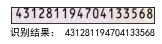

---------------------------------------


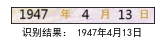

---------------------------------------


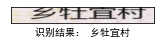

---------------------------------------


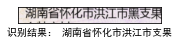

---------------------------------------


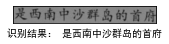

---------------------------------------


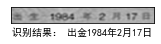

---------------------------------------


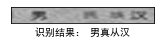

---------------------------------------


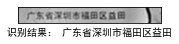

---------------------------------------


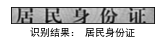

---------------------------------------


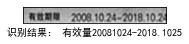

---------------------------------------


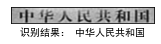

---------------------------------------


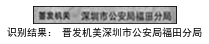

---------------------------------------


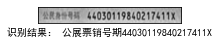

---------------------------------------


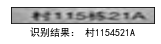

---------------------------------------


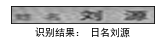

---------------------------------------


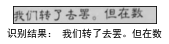

---------------------------------------


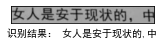

---------------------------------------


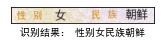

---------------------------------------


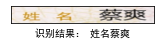

---------------------------------------


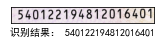

---------------------------------------


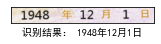

---------------------------------------


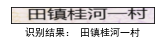

---------------------------------------


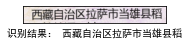

---------------------------------------


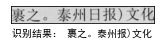

---------------------------------------


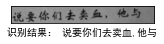

---------------------------------------


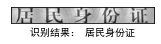

---------------------------------------


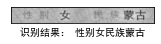

---------------------------------------


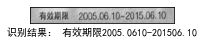

---------------------------------------


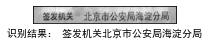

---------------------------------------


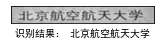

---------------------------------------


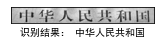

---------------------------------------


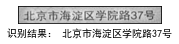

---------------------------------------


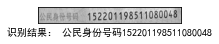

---------------------------------------


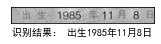

---------------------------------------


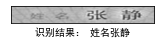

---------------------------------------


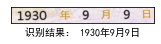

---------------------------------------


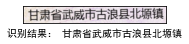

---------------------------------------


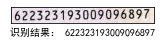

---------------------------------------


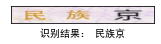

---------------------------------------


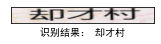

---------------------------------------


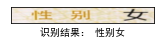

---------------------------------------


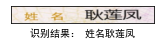

---------------------------------------


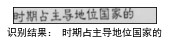

---------------------------------------


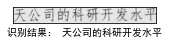

---------------------------------------


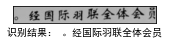

---------------------------------------


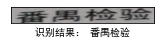

---------------------------------------


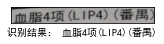

---------------------------------------


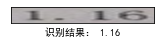

---------------------------------------


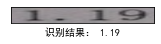

---------------------------------------


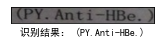

---------------------------------------


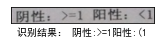

---------------------------------------


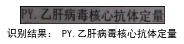

---------------------------------------


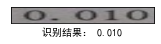

---------------------------------------


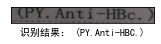

---------------------------------------


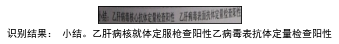

---------------------------------------


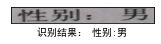

---------------------------------------


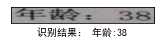

---------------------------------------


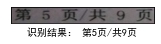

---------------------------------------


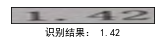

---------------------------------------


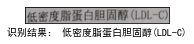

---------------------------------------


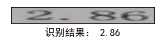

---------------------------------------


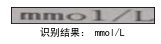

---------------------------------------


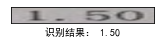

---------------------------------------


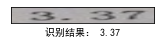

---------------------------------------


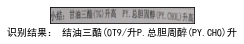

---------------------------------------


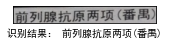

---------------------------------------


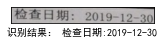

---------------------------------------


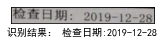

---------------------------------------


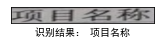

---------------------------------------


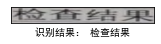

---------------------------------------


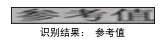

---------------------------------------


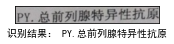

---------------------------------------


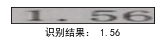

---------------------------------------


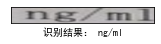

---------------------------------------


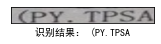

---------------------------------------


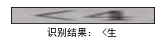

---------------------------------------


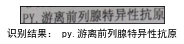

---------------------------------------


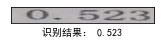

---------------------------------------


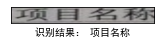

---------------------------------------


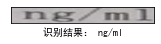

---------------------------------------


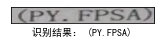

---------------------------------------


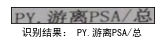

---------------------------------------


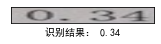

---------------------------------------


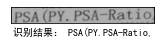

---------------------------------------


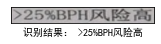

---------------------------------------


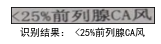

---------------------------------------


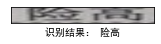

---------------------------------------


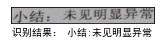

---------------------------------------


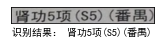

---------------------------------------


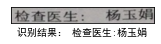

---------------------------------------


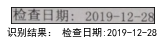

---------------------------------------


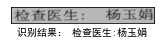

---------------------------------------


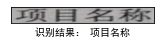

---------------------------------------


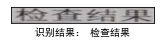

---------------------------------------


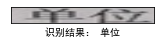

---------------------------------------


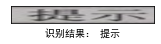

---------------------------------------


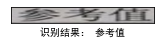

---------------------------------------


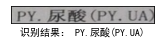

---------------------------------------


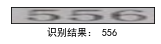

---------------------------------------


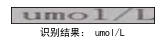

---------------------------------------


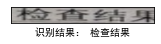

---------------------------------------


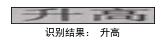

---------------------------------------


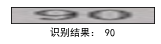

---------------------------------------


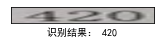

---------------------------------------


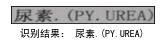

---------------------------------------


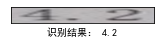

---------------------------------------


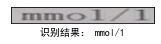

---------------------------------------


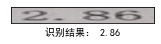

---------------------------------------


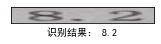

---------------------------------------


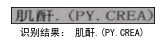

---------------------------------------


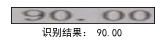

---------------------------------------


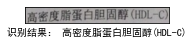

---------------------------------------


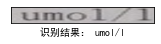

---------------------------------------


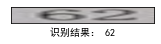

---------------------------------------


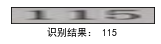

---------------------------------------


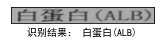

---------------------------------------


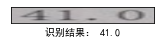

---------------------------------------


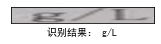

---------------------------------------


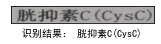

---------------------------------------


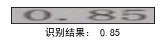

---------------------------------------


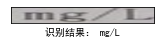

---------------------------------------


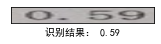

---------------------------------------


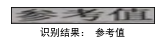

---------------------------------------


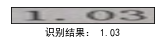

---------------------------------------


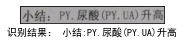

---------------------------------------


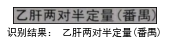

---------------------------------------


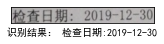

---------------------------------------


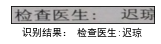

---------------------------------------


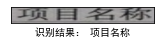

---------------------------------------


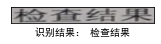

---------------------------------------


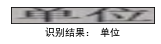

---------------------------------------


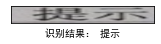

---------------------------------------


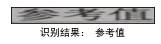

---------------------------------------


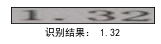

---------------------------------------


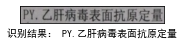

---------------------------------------


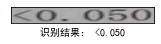

---------------------------------------


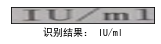

---------------------------------------


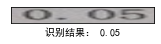

---------------------------------------


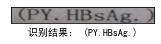

---------------------------------------


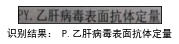

---------------------------------------


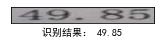

---------------------------------------


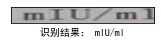

---------------------------------------


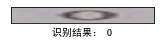

---------------------------------------


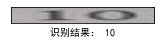

---------------------------------------


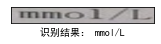

---------------------------------------


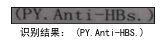

---------------------------------------


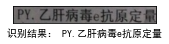

---------------------------------------


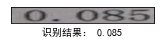

---------------------------------------


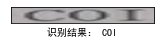

---------------------------------------


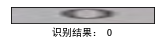

---------------------------------------


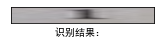

---------------------------------------


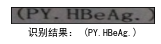

---------------------------------------


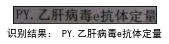

---------------------------------------


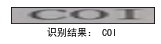

---------------------------------------


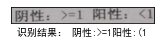

---------------------------------------


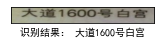

---------------------------------------


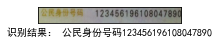

---------------------------------------


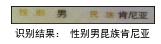

---------------------------------------


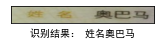

---------------------------------------


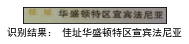

---------------------------------------


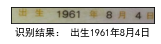

In [29]:
y_pred = decoder.decode(result, method='greedy')

for i,sentense in enumerate(y_pred):
    print('---------------------------------------')
    plt.figure(figsize=(32,80))
    plt.subplot(len(y_pred),1,i+1)
    plt.imshow(load_and_preprocess_image(test_all_image_paths[i]))
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('识别结果： '+sentense)
    plt.show()
    

## 保存模型

In [19]:
if is_save_model:
    tf.keras.models.save_model(
                                model,
                                export_path,
                                overwrite=True,
                                include_optimizer=True,
                                save_format=None,
                                signatures=None,
                                options=None
                              )
    print('模型保存成功。')

## 查看已保存的模型信息

In [20]:
#!saved_model_cli show --dir {export_path} --all

2020-07-29 18:23:05.302526: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'cudart64_101.dll'; dlerror: cudart64_101.dll not found
2020-07-29 18:23:05.303011: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.



MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 32, 280, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['output_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, -1, 5531)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Defined Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          inputs: Te

## Docker中tensorflow serving启动命令